
# Lecture 3 — Probability & Statistics II

[Open this notebook in Google Colab](https://colab.research.google.com/github/daanmeerburg/Statistics_meerburg_2026//blob/main/Lectures/Lecture_03_PDM.ipynb)


**Lecturer:** P. D. Meerburg 

*Heavily based on materials by Davide Gerosa (astroML, 2022) and collaborators. See [here](https://github.com/dgerosa/astrostatistics_bicocca_2023/blob/main/README.md) for credits.*

##### Reading:

- [Ivezic textbook](https://press.princeton.edu/books/hardcover/9780691198309/statistics-data-mining-and-machine-learning-in-astronomy) Chapter 3. 



---

In [1]:
import numpy as np
import scipy.stats
import pylab as plt
plt.rcParams['figure.figsize'] = [8, 8]

In [2]:
# Install required libraries only when running on Google Colab
import sys

def install(pkg):
    !pip install {pkg}

if 'google.colab' in sys.modules:
    print("Running in Google Colab — installing required packages...")
    for pkg in ["astroML", "astropy", "corner", "emcee"]:
        install(pkg)
else:
    print("Running locally — assuming required packages are installed.")

Running locally — assuming required packages are installed.


>## Monte Carlo integration

You might have seen this already, but Monte Carlo integration is an absolute crucial notion in modern statistics (modern because it relies on generating a large number of data points, which has been made possible by computers). Suppose you have a very complicated integral to solve and that you can write down the integrand as a product of $f(x)$ and $p(x)$ with $\int p(x)=1$ (which is not as restrictive as you might think). My nasty integral is

$$\int f(x) p(x) dx.$$


Provided one can **evaluate** $f(x)$ and **sample** $p(x)$, then


$$\int f(x) p(x) dx \approx \frac{1}{N}\sum_{i=1}^N f(x_i), $$

where $x_i$ are samples drawn from $p$. 

>**EXAMPLE 1:**.

Consider the following integral
    
$$\int_{0.3}^4 dx \frac{\exp(x) \sqrt{4x+3}  \log(x^6)}{\tanh(x)}.$$

Pen and paper? Good luck. With a computer? Easy peasy!

First, I divide and multiply by $4-0.3$. This is because (see below) 1/(4-0.3) is a uniform distribution $p(x)$ for x between 0.3 and 4, the distribution we will use to Monte Carlo intgrate (see how simple it is to write the integral as the equation above):

$$ (4-0.3) \times \int_{0.3}^{4} \frac{dx}{(4-0.3)} \frac{\exp(x) \sqrt{4x+3} * \log(x^6)}{\tanh(x)}$$

Now I have $p(x)=\frac{1}{4-0.3}$ and $f(x) = \frac{\exp(x) \sqrt{4x+3} * \log(x^6)}{\tanh(x)}$. All I need to do is generate numbers from $p$, put them into $f$, and sum the results. Let us try:

In [7]:
xmax = 4
xmin = 0.3
# random points in the unorm distribution
xi=np.random.uniform(xmin,xmax, 100000)

# function to integrate
def fun(x):
    return np.exp(x)*(4*x+3)**0.5 * np.log(x**6)/np.tanh(x)
# approximate integral using Monte Carlo
integral = (xmax-xmin) * np.mean(fun(xi))

print(integral)

1392.513150922744


Check the result:
https://www.wolframalpha.com/input/?i=integrate+from+0.3+to+4+exp%28x%29+sqrt%284x%2B3%29+*+ln%28x%5E6%29+%2Ftanh%28x%29

Run the cell again. And again.  We'll understand the errors in a bit.

**Always remember Monte Carlo integration, it's extremely useful!**

Please go ahead and try some yourself (of which you know the exact result). Monte Carlo methods are not just useful for complicated integrals — they are particularly powerful for high-dimensional integrals, where classical numerical integration becomes computationally intractable. Unlike standard methods whose cost grows exponentially with dimension, Monte Carlo converges at a rate independent of dimensionality.

---

>## Descriptive statistics 

As we've said, our goal is to estimate $h(x)$ given some measured data, allowing us to reconstruct the data-based distribution $f(x)$. An arbitrary distribution can be characterized by **location** parameters (i.e., position), **scale** parameters (i.e., width), and **shape** parameters. These parameters are called ***descriptive statistics***.

The distribution we want to learn about could be the true distribution of some physical quantity — for example, the mass distribution of dark matter halos or the energy distribution of particles created in a collider. But the data we record are not a perfect reflection of that distribution: some events are more likely to be detected than others, and measurement noise smears the values we observe.

Let's get back to the distribution we've seen already

In [8]:
# Based on Ivezic v2, Figure 6.8; edited by G. T. Richards, S. R. Taylor, and D. Gerosa +PDM 2025/2026

# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general

# --- Universal, LaTeX-free plotting setup (safe on any system) ---
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.neighbors import KernelDensity
from astropy.visualization import hist
from sklearn.mixture import GaussianMixture

# Compatibility patch for astroML / NumPy >= 1.24
if not hasattr(np, "bool"):
    np.bool = bool

# Consistent, publication-quality plot style
plt.rcParams.update({
    "font.size": 14,
    "axes.labelsize": 14,
    "axes.titlesize": 16,
    "legend.fontsize": 12,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "text.usetex": False,   # explicitly disable LaTeX rendering
    "figure.figsize": (6, 4),
    "figure.dpi": 100
})

%config InlineBackend.figure_format = 'retina'

In [9]:
# Generate our data: a mix of several Cauchy distributions (see Chapter 3.3.5)
# In reality nature generates data for you

random_state = np.random.RandomState(seed=0)
N = 2000 # number of data points--> you can make this larger if you want a smoother result.
#define an array of (mu, gamma, f) tuples
mu_gamma_f = [(5, 1.0, 0.1),
              (7, 0.5, 0.5),
              (9, 0.1, 0.1),
              (12, 0.5, 0.2),
              (14, 1.0, 0.1)]
#generate the true distribution function using the array above
hx = lambda x: sum([f * stats.cauchy(mu, gamma).pdf(x)
                          for (mu, gamma, f) in mu_gamma_f])
#generate random samples from the true distribution function
x = np.concatenate([stats.cauchy(mu, gamma).rvs(int(f * N), random_state=random_state)
                    for (mu, gamma, f) in mu_gamma_f])
# Shuffle and trim the data to a reasonable range
random_state.shuffle(x)
x = x[x > -10]
x = x[x < 30]

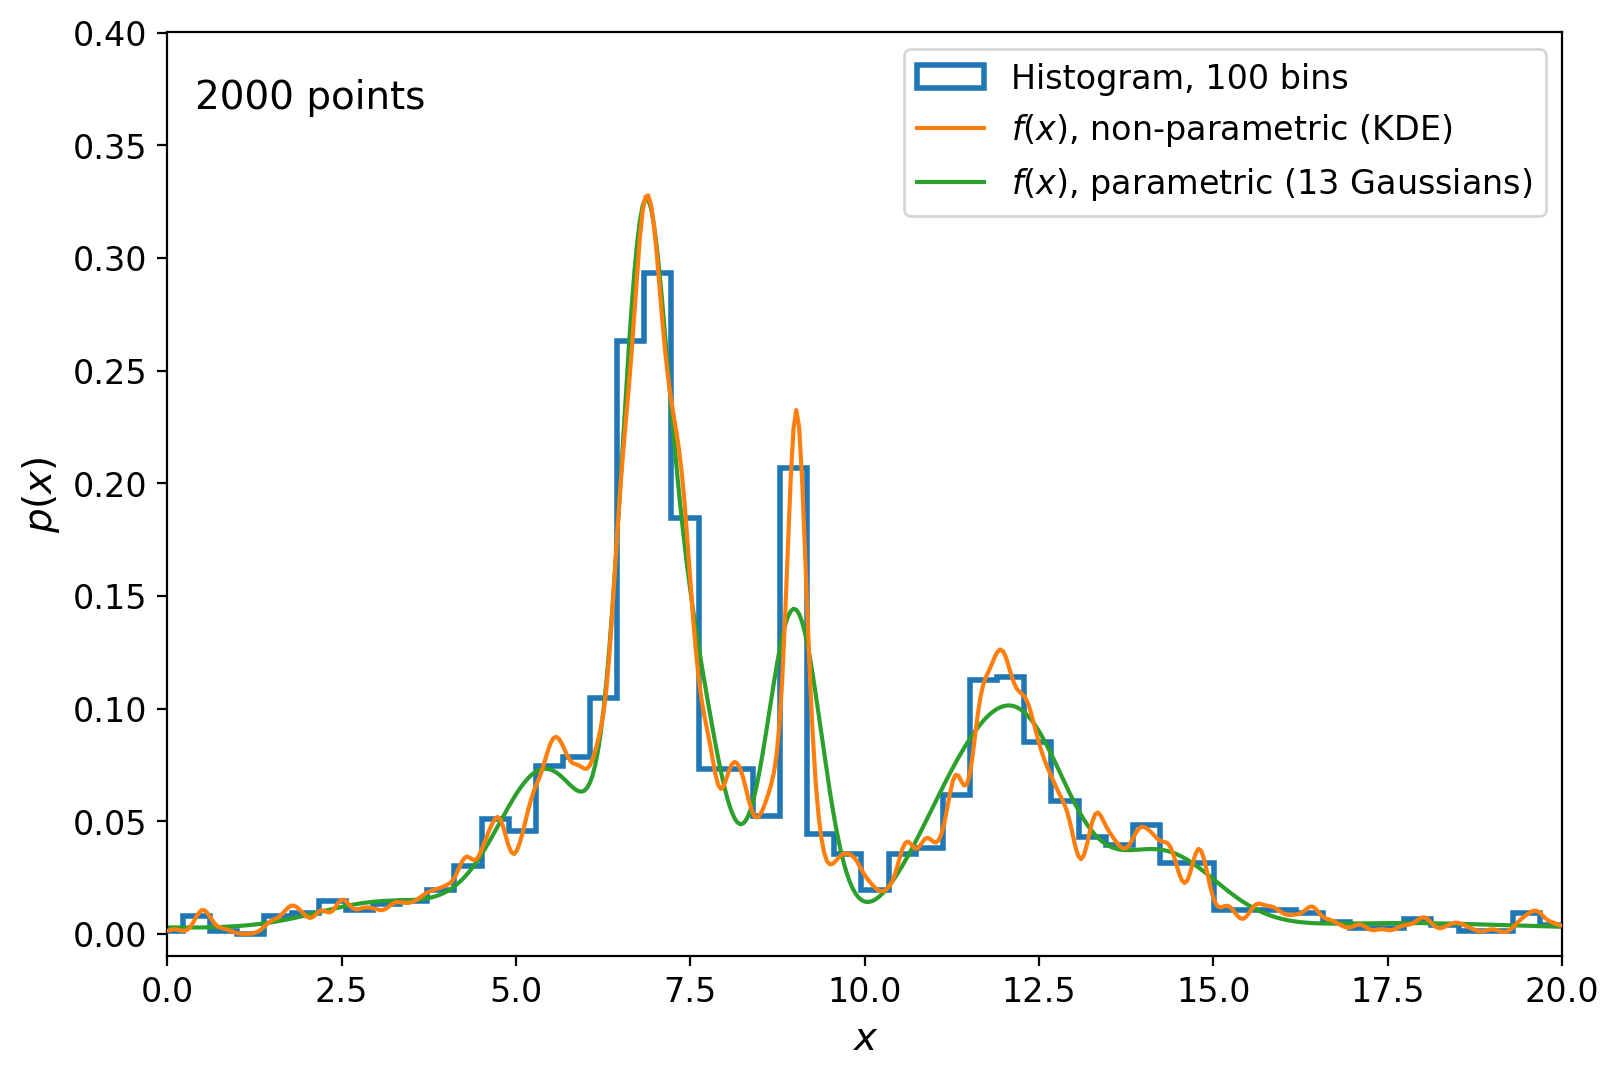

In [10]:
# plot the results
fig,ax = plt.subplots(figsize=(9, 6))
xgrid = np.linspace(-10, 30, 1000)

# True distribution: you typically don't have it! Only have the samples!
if False:
    ax.plot(xgrid, hx(xgrid), ':', color='black', zorder=3,
            label="$h(x)$, Generating Distribution")

# A simple histogram
# But try changing the number of bins!
if True:
    ax.hist(x,density=True,color='C0',bins=100,histtype='step',lw=2, label='Histogram, 100 bins')

# Something more sophisticated: Kernel Density Estimation, see section 6.1.1
# But try changing the bandwith! 
if True:
    kde = KernelDensity(bandwidth=0.1, kernel='gaussian')
    kde.fit(x[:, None])
    dens_kde = np.exp(kde.score_samples(xgrid[:, None]))
    ax.plot(xgrid, dens_kde, '-', color='C1', zorder=3,
            label="$f(x)$, non-parametric (KDE)")

# Use Gaussian Mixtures with a pre-defined number of clusters (13), see section 6.3.1
if True:
    gmm = GaussianMixture(n_components=13).fit(x.reshape(-1, 1))
    logprob = gmm.score_samples(xgrid.reshape(-1, 1))
    fx = lambda j : np.exp(gmm.score_samples(j.reshape(-1, 1)))
    ax.plot(xgrid, fx(np.array(xgrid)), '-', color='C2',
            label="$f(x)$, parametric (13 Gaussians)")

# Plot cosmetics
ax.text(0.02, 0.95, "%i points" % N, ha='left', va='top',
            transform=ax.transAxes)

ax.set_ylabel('$p(x)$',fontsize=14)
ax.legend(loc='upper right')

ax.set_xlabel('$x$',fontsize=14)
ax.set_xlim(0, 20)
ax.set_ylim(-0.01, 0.4001)

plt.show()

We all know that the **mean** of a sample is 

$$ \bar{x} = \frac{1}{N}\sum_{i=1}^N x_i $$

This is actually known as the **sample arithmetic mean**, and derives from *Monte Carlo integration* to get the first moment of the distribution, i.e. 

$$\mu = E(x) = \langle x \rangle = \int_{-\infty}^{\infty} x h(x)\,dx \approx \frac{1}{N}\sum_{i=1}^N x_i $$

where $\{x_i\}$ are random samples from the properly normalized $h(x)$, and $E(\cdot)$ means the **expectation value**.

In [11]:
data =x.copy() #This copying step is important because it allows you to manipulate or 
#modify data in later operations without affecting the original dataset stored in x. 
#This is a common practice in data analysis to preserve the integrity of the original data.

mean = np.mean(data)
print(mean)

8.79491032639886


While it's most common to compute the mean, it may surprise you to learn that some distributions do not have formally calculable means (integration gives infinity). In these and other cases, the **median** is a more *robust* estimator of the (true) mean location of the distribution.  That's because it is less affected by **outliers**.

To understand the previous statement, think about multiplying all numbers above the 50th percentile (i.e. the median) by 100, or even just replacing them with larger numbers. The mean would be strongly affected by these corrupted points, but **cumulative statistics based on the ordering of samples would remain unaffected by the outlier corruption**.

In [13]:
median = np.median(data)
print(median)

7.752731764708434


In [12]:
# Try to unpack what is happening here
median = np.median(data)
# mask data above 15, create new array of the data (data2) (note that this is savely above the 50 percentile)
mask = data > 15
data2 = data.copy()
#all data above a value of 15 is now replaced with 10000. 
data2[mask] = 10000

newmedian = np.median(data2)
newmean = np.mean(data2)

print(median, newmedian)
print(mean, newmean)

7.752731764708434 7.752731764708434
8.79491032639886 425.52602287925964


So there is a very large difference in the mean when you remove all data above some threshold and replace it with a large number. However, the median is unaffected. If you change numbers below the 50 percentile, the median will be affected. 

Other descriptive statistics are related to higher order moments of the distribution. Beyond the "average" *location* value, we'd like to know something about **deviations** from the average (which is related to the *shape* of the distribution).  The simplest thing to compute is $$d_i = x_i - \mu.$$  However, the average deviation is zero by definition of the mean, i.e. $\langle x_i - \mu \rangle = 0 $.  The next simplest thing to do is to compute the **mean absolute deviation (MAD)**:

$$\frac{1}{N}\sum|x_i-\mu|,$$

but the absolute values can hide the true scatter of the distribution [(example)](http://www.mathsisfun.com/data/standard-deviation.html). The next simplest thing to do is to square the differences $$\sigma^2 = \frac{1}{N}\sum(x_i-\mu)^2,$$ which you might recognize as the **variance**.

The *variance* $V$ is the just expectation value of $(x-\mu)^2$ (and related to the 2nd moment)

$$\sigma^2 = V = E((x-\mu)^2)\int_{-\infty}^{\infty}  (x-\mu)^2 h(x) dx,$$

where $\sigma$ is the **standard deviation**. Again, the integral gets replaced by a sum for discrete distributions. While most familiar for Gaussian distributions, you can compute the variance even if your distribution is not Gaussian.  

In [13]:
var = np.var(data)
std = np.std(data)
print(var, std)
print(np.isclose(std**2,var)) #Why am I not doing std**2==var? A:Because of numerical precision. 

15.026052739760306 3.8763452812875565
True


There is also the **Median Absolute Deviation (also MAD)** given by

$${\rm median} (|x_i-{\rm median}(\{x_i\})|)$$

where $\sigma = 1.4826\,{\rm MAD}$ for a Gaussian distribution (but note that we aren't using a Gaussian distribution above).

In [14]:
from astropy.stats import median_absolute_deviation
MAD = median_absolute_deviation(data)
print(MAD,MAD*1.4826)

1.681113066473134 2.492418232353068


**$P\%$ quantiles (or the $p^\mathrm{th}$ percentile, $q_p$)** are computed as
$$\frac{p}{100} = H(q_p) = \int_{-\infty}^{q_p}h(x) dx$$

The full integral from $-\infty$ to $\infty$ is 1 (100%).  So, here you are looking for the value of x that accounts for $p$ percent of the distribution.

For example, the 25th, 50th, and 75th percentiles:

In [15]:
# Execute this cell
q25, q50, q75 = np.percentile(data, [25, 50, 75])
print(q25, q50, q75)

6.674995612577169 7.752731764708434 11.637549888596837


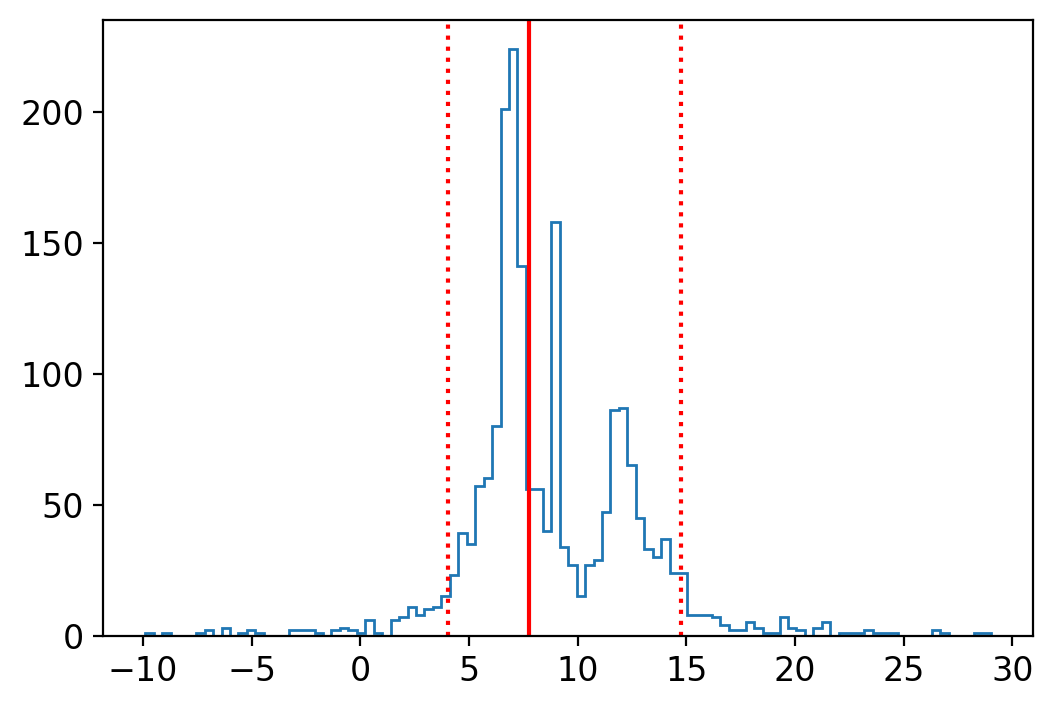

In [18]:
plt.figure(figsize=(6, 4))

plt.hist(data,bins=100,histtype='step');
plt.axvline(np.percentile(data,50),c='red')
plt.axvline(np.percentile(data,5),c='red',ls='dotted')
plt.axvline(np.percentile(data,95),c='red',ls='dotted')

The region between the 5th and the 95th percentile contains 90% of the samples. In Bayesian statistics, this is the 90% credible interval.

The **interquartile range** is the difference between the 25th and 75th percentiles, $q_{75} - q_{25}$.

Just as with the median, the interquartile range is a more *robust* estimator of the scale of a distribution than the standard deviation.  So, one can create a standard-deviation-esque measurement (at least for a Gaussian) from the interquartile range as

$$\sigma_G = 0.7413\times(q_{75} - q_{25})$$

The normalization makes it *unbiased* for a perfect Gaussian (more on that later).

In [16]:
# Execute this cell. Think about and discuss the results.
from astroML import stats as astroMLstats

# original data
print(astroMLstats.sigmaG(data), np.std(data))

# corrupted by outliers
print(astroMLstats.sigmaG(data2), np.std(data2))

3.678746989540611 3.8763452812875565
3.678746989540611 1998.538847396505


So you see that $\sigma_G$ is a much better indicator of the shape then the STD. The STD is heavily affected by outliers. 

In [ ]:
# Execute this cell. Cumulative statistics take longer to compute, but are more robust. -- we call them cumulative because they are based on the cumulative distribution function, which is less sensitive to outliers than the mean and standard deviation.
%timeit np.mean(data), np.std(data)
%timeit np.median(data), astroMLstats.sigmaG(data)

20.6 μs ± 601 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
105 μs ± 690 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


The **mode** is the most probable value, determined from the peak of the distribution, which is the value where the derivative is 0 (i.e. the turning point):

$$ \left(\frac{dh(x)}{dx}\right)_{x_m} = 0.$$

A good approximation for the mode is (the distribution needs to be somewhat close to Gaussian, for a proof: [Lupton 1993](https://press.princeton.edu/books/hardcover/9780691074290/statistics-in-theory-and-practice))

$$x_m \simeq 3q_{50} - 2\mu.$$



In [18]:
# Execute this cell
mode = 3*q50 - 2*mean
print(mode, mean, median)

# Note: don't rely on scipy.stats.mode()!!
# It gives the most common value of an array, 
# but we have a random sample of unique draws
print(scipy.stats.mode(data), "This is non sense!")

5.668374641327581 8.79491032639886 7.752731764708434
ModeResult(mode=np.float64(-9.890167554081604), count=np.int64(1)) This is non sense!


Other useful ***shape*** measures include the "higher order" moments (the **skewness** and **kurtosis**):

$$\mathbf{Skewness}\quad\quad \Sigma = \int_{-\infty}^{\infty}  \left(\frac{x-\mu}{\sigma}\right)^3 h(x) dx,$$
 
$$\mathbf{Kurtosis}\quad\quad K = \int_{-\infty}^{\infty}  \left(\frac{x-\mu}{\sigma}\right)^4 h(x) dx  - 3.$$

The skewness measures the distribution's *asymmetry*. Distribution's with long tails to larger $x$ values have positive $\Sigma$. 

The kurtosis measures how peaked or flat-topped a distribution is, with strongly peaked ones being positive and flat-topped ones being negative. $K$ is calibrated to a Gaussian distribution (hence the subtraction of $3$).

![https://www.astroml.org/_images/fig_kurtosis_skew_1.png](https://www.astroml.org/_images/fig_kurtosis_skew_1.png)

In [19]:
skew = scipy.stats.skew(data)
kurt = scipy.stats.kurtosis(data)
print(skew, kurt)

0.45629831452598973 3.2486771861658417


**Pill of modern cosmology from my research.** One of my main science goals is to search of deviations from non-Gaussian statistics in cosmological observables. It is easy to show that the lowest order correction to the moment of a distribution if the distribution becomes weakly non-Gaussian appears in the skewness. Here we are considering strings of numbers (data vector). If we want to compute statistics of a field, which is a vector that has a value for each point in space and time, we instead compute correlators. For example, the two-point correlator computes the ensemble average of the correlation between two random points in the field. It turns out that the cosmological principle, which states that the universe is isotropic and homogeneous, has very nice implications for the Fourier transformed correlators (we will talk about this later). In Fourier (or harmonic) space, $n$-point correlators, become $n-1$-spectra. So for example, you can think about the power spectrum, which is the Fourier transform of the 2-point correlator, as the variance of the field as a function of scale.  The bispectrum, the Fourier transform of the 3-point correlator, is the most sensitive to small deviations from non-Gaussianity.  


In [20]:
# Summary descriptive statistics for our distribution
print("Location: ", mean, median, mode)
print("Scale: ", var, std, astroMLstats.sigmaG(data))
print("Shape: ", skew, kurt)
print("Some percentiles: ", q25, q50, q75)

Location:  8.79491032639886 7.752731764708434 5.668374641327581
Scale:  15.026052739760306 3.8763452812875565 3.678746989540611
Shape:  0.45629831452598973 3.2486771861658417
Some percentiles:  6.674995612577169 7.752731764708434 11.637549888596837


---

>## Sample versus Population statistics <a class="anchor" id="two"></a>

Statistics estimated from the *data* are called **sample statistics** as compared to **population statistics** derived from knowing the functional form of the pdf.

Specifically, $\mu$ is the **population mean**, i.e., it is the expectation value of $x$ for $h(x)$.  But we don't *know* $h(x)$.  So the **sample mean**, $\overline{x}$, is an ***estimator*** of $\mu$, defined as (in cosmology we typically write $\hat{x}$ instead of $\overline{x}$)

$$\overline{x} \equiv \frac{1}{N}\sum_{i=1}^N x_i,$$

which we determine from the data itself.

Instead of the **population variance** $\sigma^2$, we have the **sample variance**, $s^2$, where

$$s^2 = \frac{1}{N-1}\sum_{i=1}^N(x_i-\overline{x})^2$$

The $N-1$ denominator (instead of $N$) accounts for the fact that we determine $\overline{x}$ from the data itself instead of using a known $\mu$. This is called [Bessel's correction](https://en.wikipedia.org/wiki/Bessel%27s_correction).

Ideally one tries to work in a regime where $N$ is large enough that we can be lazy and ignore this. 

So the mean and variance of a distribution are $\mu$ and $\sigma^2$.  The *estimators* of the distribution are $\overline{x}$ (or $\hat{x}$) and $s^2$.

**Uncertainty of sample statistics**

We would also like to know the uncertainty of our estimates $\overline{x}$ and $s$. 

Note that $s$ is the width estimate of the underlying distribution; it is **NOT** the uncertainty of $\overline{x}$. This is a common misconception.

Rather the uncertainty of $\overline{x}$, $\sigma_{\overline{x}}$ is 

$$ \sigma_{\overline{x}} = \frac{s}{\sqrt{N}},$$

which we call the **standard error of the mean**. The uncertainty of $s$ itself is

$$\sigma_s = \frac{s}{\sqrt{2(N-1)}} = \frac{1}{\sqrt{2}}\sqrt{\frac{N}{N-1}}\sigma_{\overline{x}}.$$

Note that for large $N$, $\sigma_{\overline{x}} \sim \sqrt{2}\sigma_s$ and for small $N$, $\sigma_s$ is not much smaller than $s$.

Another useful uncertainty estimate is for computing quantiles. The **standard error of a quantile** is

$$ \sigma_{q_p} = \frac{1}{h_p}\sqrt{\frac{p(1-p)}{N}},$$

where $p$ is between $0$ and $1$.  

>## Example

- Generate some data
- Compute $\overline{x}$ and $s$
- Do this many times (e.g. 100)
- Estimate the errors
- Compare with the expressions above

The best approach would be to write a function that generates the data (of length $L$, and with distribution parameters $\Theta_i$) and computes $\overline{x}$ and $s$ $N$ times, with $N$ the number of generated distributions. The output should be this vector. The vector can then simply be plotted as function of $N$. So to get started, write something like:


In [21]:
def gen(L, N, Theta, seed=None):
    results = []
    mean, std = Theta[0]
    
    # Set the seed for reproducibility if provided
    if seed is not None:
        np.random.seed(seed)
    
    for i in range(N):
        # Generate data based on the parameters in Theta
        data = np.random.normal(loc=mean, scale=std, size=L)
        
        # Compute sample mean and sample variance
        x_bar = np.mean(data)
        s = np.std(data)
        
        # Append the results as a tuple (mean, std)
        results.append((x_bar, s))
    
    # Convert results to a numpy array for easier manipulation
    return np.array(results)

# Example usage:
# L = 1000 (length of each generated dataset)
# N = 10 (number of distributions to generate)
# Theta = [(mean1, std1), (mean2, std2), ..., (meanN, stdN)]
Theta = [(0, 1)]
L = 1000
N = 1000
# Remove the seed or set it to None for different realizations
seed = None  # Set to None for random seed

results = gen(L, N, Theta, seed)

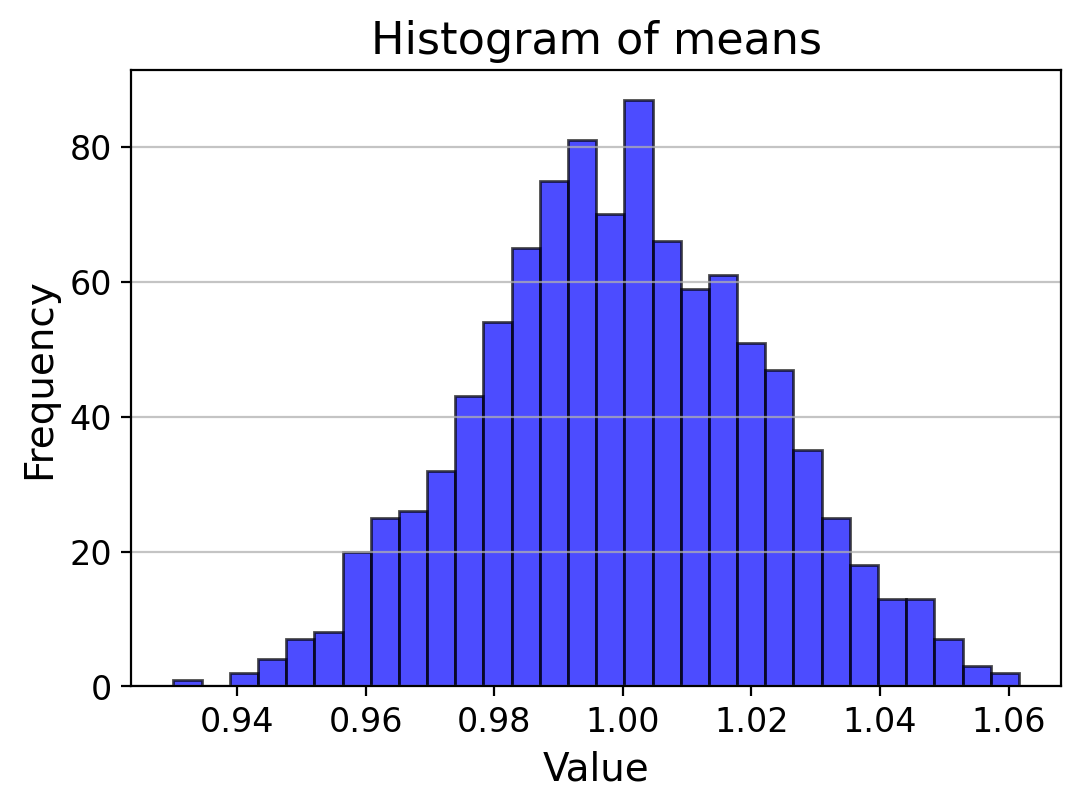

In [22]:

# Create a histogram of the data
plt.figure(figsize=(6, 4))
plt.hist(results[:,1], bins=30, color='blue', alpha=0.7, edgecolor='black')
plt.title('Histogram of means')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()


In [23]:
print("Std of sample means:", np.std(results[:,0]))
print("Std of sample stds:", np.std(results[:,1]))

Std of sample means: 0.030250137161710534
Std of sample stds: 0.02212301919909801


In [24]:
print("theoretical std of sample means:", 1/np.sqrt(L))  # Theoretical std of the mean for normal distribution
print("theoretical mean of std of samples:", 1/np.sqrt(2 * (L-1)))  # Theoretical std of the normal distribution

theoretical std of sample means: 0.03162277660168379
theoretical mean of std of samples: 0.022371868507134143


Not bad, but you can check that when you increase $L$ this should get better and better. 

---

>## Univariate distributions (and an intro to scipy.stats)

If we are attempting to characterize our data in a way that is **parameterized**, then we need a functional form for a **distribution**.  There are many naturally occurring distributions.  The book goes through quite a few of them.  Here we'll just talk about a few basic ones to get us started.

### Uniform Distribution

The uniform distribution is perhaps more commonly called a "top-hat" or a "box" distribution.  It is specified by a mean, $\mu$, and a width, $W$, where

$$p(x|\mu,W) = \frac{1}{W},$$

over the range $|x-\mu|\le \frac{W}{2}$ and $0$ otherwise.  That says that "given $\mu$ AND $W$, the probability of $x$ is $\frac{1}{W}$" (as long as we are within a certain range).

Since we are used to thinking of a Gaussian as the *only* type of distribution the concept of $\sigma$ (aside from the width) may seem strange.  But $\sigma$ as mathematically defined above applies here and
$$\sigma = \frac{W}{\sqrt{12}}.$$


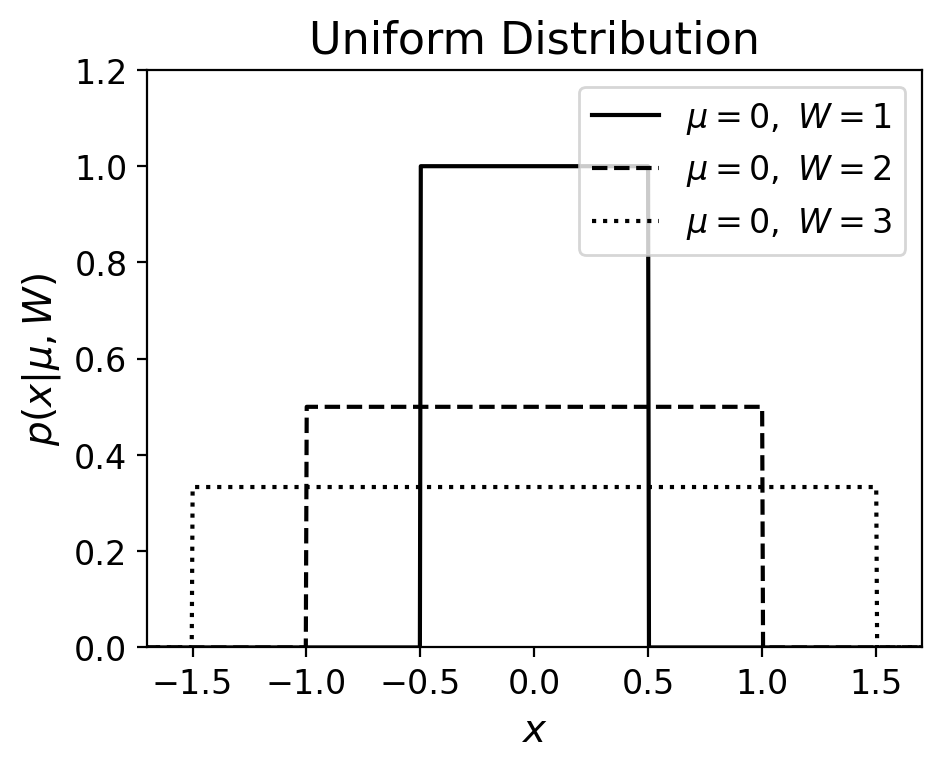

In [25]:
"""
Example of a uniform distribution
---------------------------------
Figure 3.7.
This shows an example of a uniform distribution with various parameters.
We'll generate the distribution using::
    dist = scipy.stats.uniform(...)
Where ... should be filled in with the desired distribution parameters
Once we have defined the distribution parameters in this way, these
distribution objects have many useful methods; for example:
* ``dist.pmf(x)`` computes the Probability Mass Function at values ``x``
  in the case of discrete distributions
* ``dist.pdf(x)`` computes the Probability Density Function at values ``x``
  in the case of continuous distributions
* ``dist.rvs(N)`` computes ``N`` random variables distributed according
  to the given distribution
Many further options exist; refer to the documentation of ``scipy.stats``
for more details.
"""
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
from scipy.stats import uniform
from matplotlib import pyplot as plt


#------------------------------------------------------------
# Define the distribution parameters to be plotted
W_values = [1.0, 2.0, 3.0]
linestyles = ['-', '--', ':']
mu = 0
x = np.linspace(-2, 2, 1000)

#------------------------------------------------------------
# plot the distributions
fig, ax = plt.subplots(figsize=(5, 3.75))

for W, ls in zip(W_values, linestyles):
    left = mu - 0.5 * W
    dist = uniform(left, W)

    plt.plot(x, dist.pdf(x), ls=ls, c='black',
             label=r'$\mu=%i,\ W=%i$' % (mu, W))

plt.xlim(-1.7, 1.7)
plt.ylim(0, 1.2)

plt.xlabel('$x$')
plt.ylabel(r'$p(x|\mu, W)$')
plt.title('Uniform Distribution')

plt.legend()
plt.show()

We can implement [uniform](http://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.uniform.html#scipy.stats.uniform) in `scipy` as follows.  We'll use the methods listed at the bottom of the link to complete the cell: `dist.rvs(size=N)` which produces `N` random draws from the distribution and `dist.pdf(x)` which returns the value of the pdf at a given $x$. Lots of distributions can be accessed and used in a similar way.  

Create a uniform distribution with parameters `loc=0`, `scale=2`, and `N=1000`.

0.5


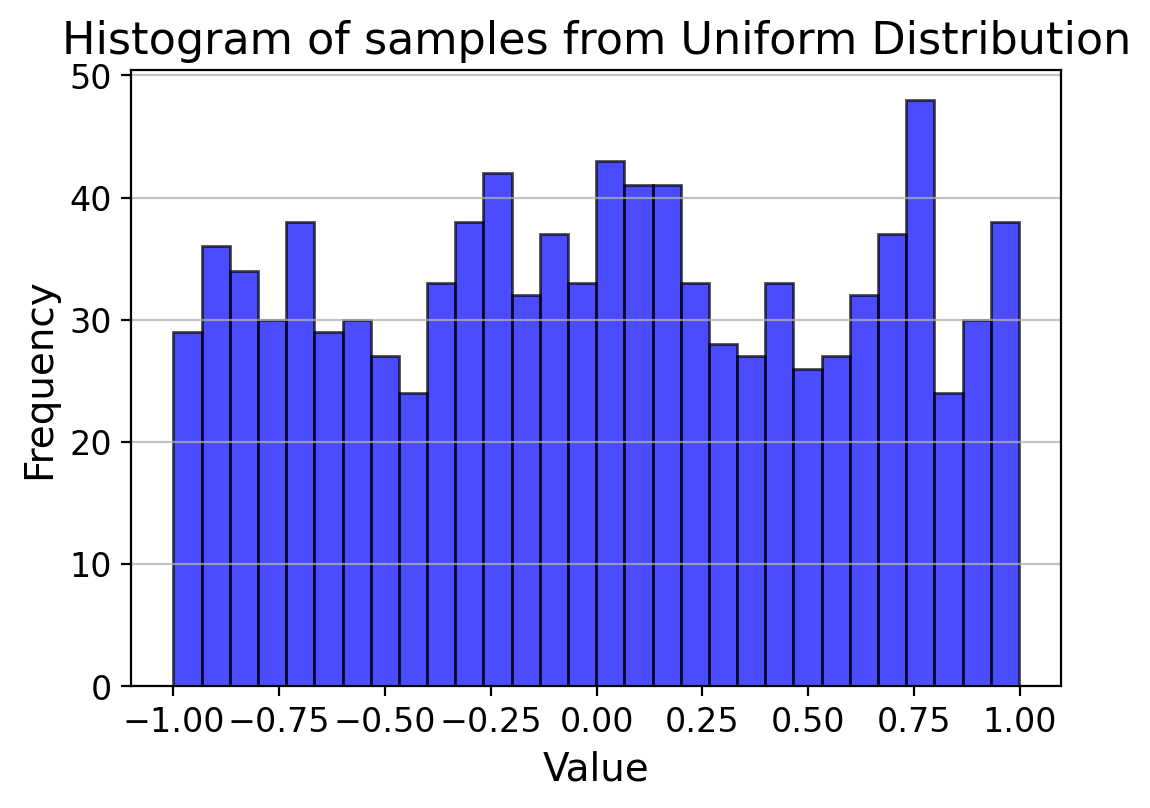

In [27]:
N = 1000 
distU = scipy.stats.uniform(-1,2) # This is a uniform distribution with mean -1 and width 2, so it goes from -1 to 1.
draws = distU.rvs(N) # ten random draws
#print(draws)

p = distU.pdf(1) # pdf evaluated at x=1

print(p)

plt.figure(figsize=(6, 4))
plt.hist(draws, bins=30, color='blue', alpha=0.7, edgecolor='black')
plt.title('Histogram of samples from Uniform Distribution')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()


### Gaussian Distribution

As many of you know, the Gaussian distribution pdf is given by

$$p(x|\mu,\sigma) = \frac{1}{\sigma\sqrt{2\pi}} \exp\left(\frac{-(x-\mu)^2}{2\sigma^2}\right).$$

It is also called the **normal distribution** and can be noted by $\mathscr{N}(\mu,\sigma)$.


We love using Gaussians in physics and astronomy because they can approximate many distributions and are also super easy to work with. **The convolution of two Gaussians results in a Gaussian.**  So $\mathscr{N}(\mu_1,\sigma_1)$ convolved with $\mathscr{N}(\mu_2,\sigma_2)$ is $\mathscr{N}(\mu_1+\mu_2,\sqrt{\sigma_1^2+\sigma_2^2})$.

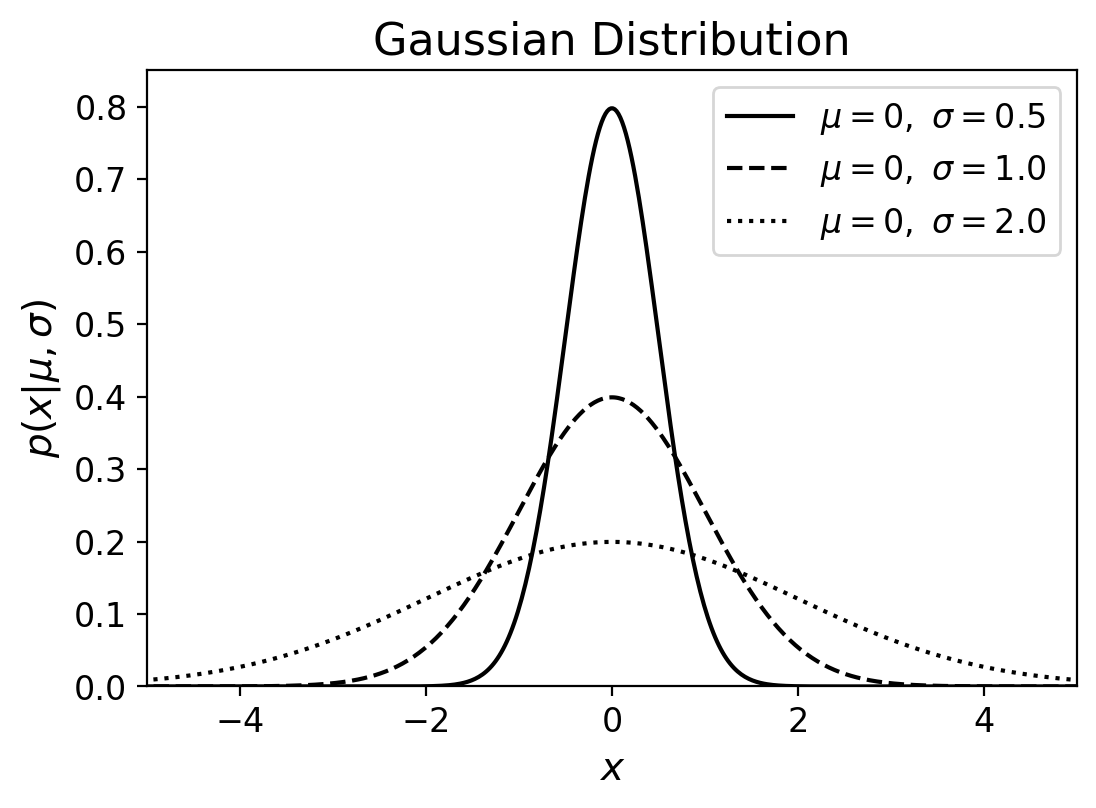

In [28]:
"""
Example of a Gaussian distribution
----------------------------------
Figure 3.8.
This shows an example of a gaussian distribution with various parameters.
We'll generate the distribution using::
    dist = scipy.stats.norm(...)
Where ... should be filled in with the desired distribution parameters
Once we have defined the distribution parameters in this way, these
distribution objects have many useful methods; for example:
* ``dist.pmf(x)`` computes the Probability Mass Function at values ``x``
  in the case of discrete distributions
* ``dist.pdf(x)`` computes the Probability Density Function at values ``x``
  in the case of continuous distributions
* ``dist.rvs(N)`` computes ``N`` random variables distributed according
  to the given distribution
Many further options exist; refer to the documentation of ``scipy.stats``
for more details.
"""
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
from scipy.stats import norm
from matplotlib import pyplot as plt

# Define the distributions to be plotted
sigma_values = [0.5, 1.0, 2.0]
linestyles = ['-', '--', ':']
mu = 0
x = np.linspace(-10, 10, 1000)

#------------------------------------------------------------
# plot the distributions
fig, ax = plt.subplots(figsize=(6,4))

for sigma, ls in zip(sigma_values, linestyles):
    # create a gaussian / normal distribution
    dist = norm(mu, sigma)

    plt.plot(x, dist.pdf(x), ls=ls, c='black',
             label=r'$\mu=%i,\ \sigma=%.1f$' % (mu, sigma))

plt.xlim(-5, 5)
plt.ylim(0, 0.85)

plt.xlabel('$x$')
plt.ylabel(r'$p(x|\mu,\sigma)$')
plt.title('Gaussian Distribution')

plt.legend()
plt.show()

In [29]:
distG = scipy.stats.norm(loc =100 , scale=15) # Normal distribution with mean = 100, stdev = 15
draws = distG.rvs(N) # 1000 random draws
p = distG.pdf(0) # pdf evaluated at x=0

print(draws)
print(p)

[ 73.1411966   86.87149375 111.25239426 112.00505281 109.69490971
  82.24670453 107.43047538  79.52585486  86.81101368 100.52770598
 100.58669406 110.15162199 147.87896873  93.58526905  94.66280891
  80.64887197 121.83120182  98.37542894  71.02483593  88.96680907
  83.46968529 110.88502082  93.95822796  95.91416776 116.49750398
 100.82335975  91.68598043  99.53162048 116.27446315 102.18599871
 116.13325343 101.72410634 122.86766937 109.23619095  93.59908805
  81.9837077   99.6114903   88.47354712 113.16652285  85.60650918
 101.10197769 128.03911628 103.26896336  77.07032848 114.85146822
 108.09904471  59.31109204  86.52903362  84.91238112  83.16209529
  79.18213891 114.5551298   90.4049698   83.6905323   84.97667011
  98.48880077  80.5957197  121.26374077 117.31313249  77.60551382
 114.59158135  86.74213596  78.44074384 107.66852288  82.5652208
 102.13232928  98.6527708   72.05834653  58.55579382 118.6794712
  90.91248148 142.15917504  99.41263399  89.10189325  76.99824447
  59.7160194

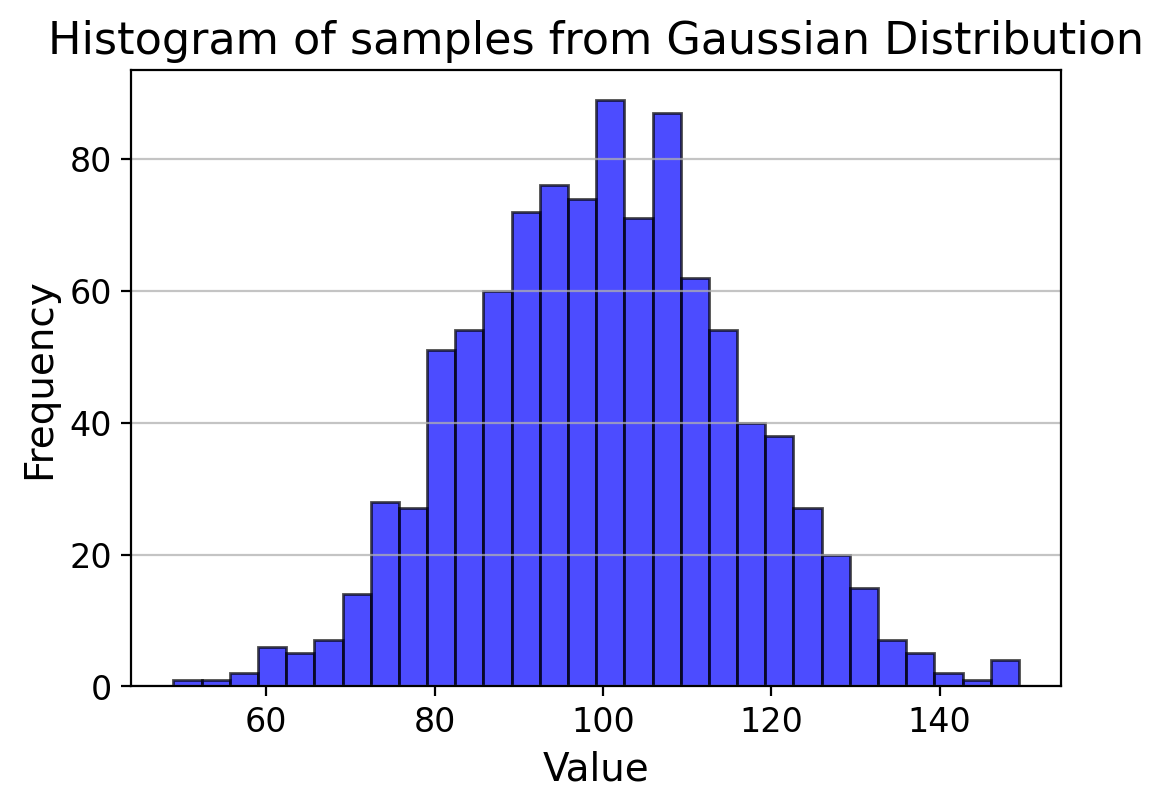

In [30]:
plt.figure(figsize=(6, 4))
plt.hist(draws, bins=30, color='blue', alpha=0.7, edgecolor='black')
plt.title('Histogram of samples from Gaussian Distribution')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

The cumulative distribution function, cdf is the integral of pdf from $x'=-\infty$ to $x'=x$:

$$\mathrm{cdf}(x|\mu,\sigma) = \int_{-\infty}^{x'} p(x'|\mu,\sigma) dx',$$

where $\mathrm{cdf}(\infty) = 1$. 

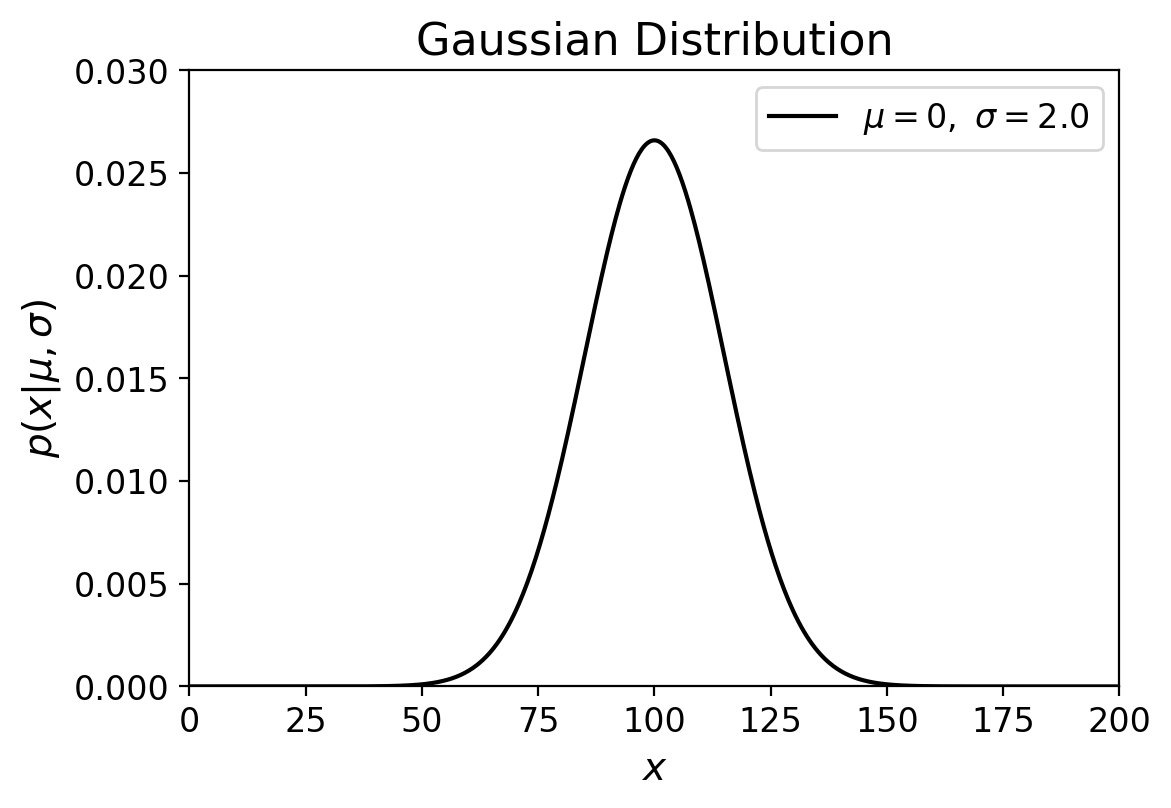

In [31]:
## Let's play with Gaussians! Or Normal distributions, N(mu,sigma)

xgrid = np.linspace(-100,200,1000) # generate distribution for a uniform grid of x values
gaussPDF = distG.pdf(xgrid)  # this is a function of xgrid

# actual plotting
fig, ax = plt.subplots(figsize=(6,4))

# Python3 f strings are awesome!
plt.plot(xgrid, gaussPDF, ls='-', c='black', 
         label=f'$\mu={mu},\ \sigma={sigma}$')
plt.xlim(0, 200)
plt.ylim(0, 0.03)
plt.xlabel('$x$')
plt.ylabel(r'$p(x|\mu,\sigma)$')
plt.title('Gaussian Distribution')
plt.legend();

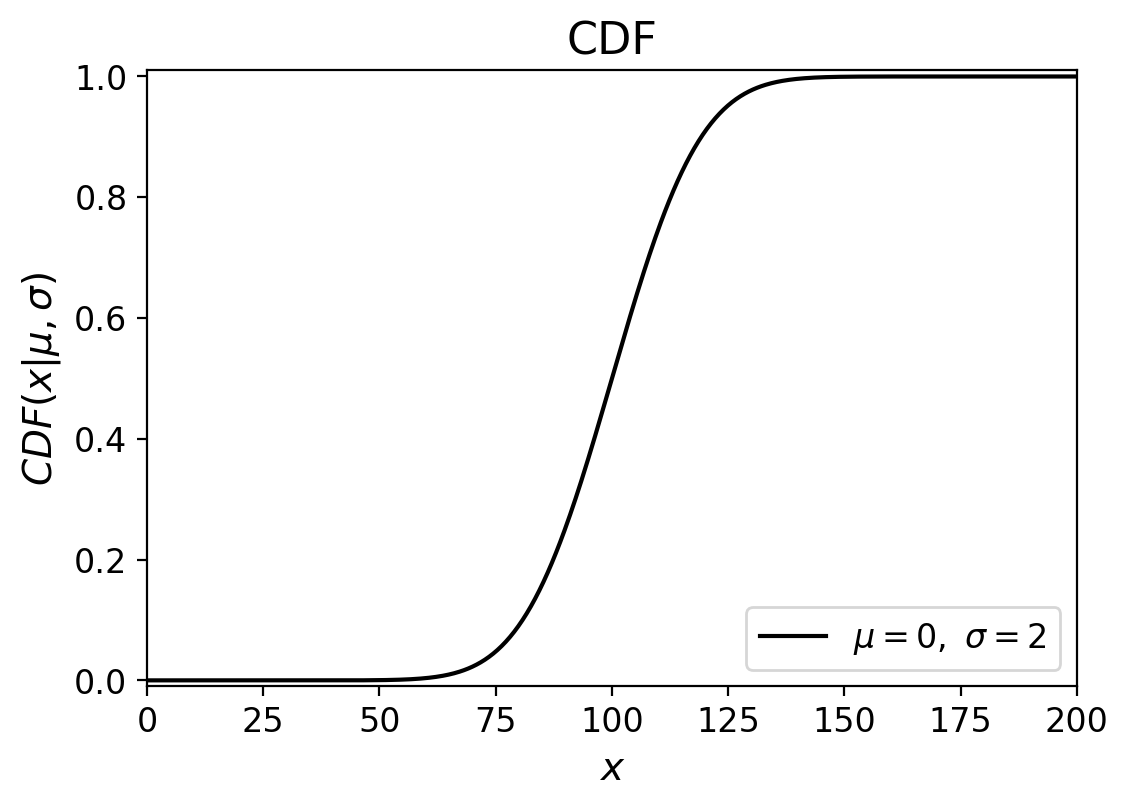

In [32]:
# The same as above but now with the cdf method
gaussCDF = distG.cdf(xgrid)
fig, ax = plt.subplots(figsize=(6,4))
plt.plot(xgrid, gaussCDF, ls='-', c='black', 
         label=r'$\mu=%i,\ \sigma=%i$' % (mu, sigma))
plt.xlim(0, 200)
plt.ylim(-0.01, 1.01)
plt.xlabel('$x$')
plt.ylabel(r'$CDF(x|\mu,\sigma)$')
plt.title('CDF')
plt.legend(loc=4)

### Gaussian confidence levels

The probability of a measurement drawn from a Gaussian distribution that is between $\mu-a$ and $\mu+b$ is

$$\int_{\mu-a}^{\mu+b} p(x|\mu,\sigma) dx.$$

- For $a=b=1\sigma$, we get the familar result of 68.3%.  
- For $a=b=2\sigma$ it is 95.4%.  
- For $a=b=3\sigma$ it is 99.7%. 

So we refer to the range $\mu \pm 1\sigma$, $\mu \pm 2\sigma$, and $\mu \pm 3\sigma$ as the 68%, 95%, and 99.7% **confidence limits**, respectively. Note that if your distribution is not Gaussian, then these confidence intervals will be different!

***We often still refer to uncertainty regions of distributions as $1\sigma$ or $2\sigma$ regions, which for non-Gaussian distributions usually means (for $1\sigma$) the region enclosing the $16\%$ and $84\%$ quantiles.***

In [ ]:
upper = distG.cdf(100+15)# This is the cumulative distribution function evaluated at x=100+15, which is the mean plus one standard deviation. It gives us the probability that a random variable drawn from this distribution will be less than or equal to 115.
lower = distG.cdf(100-15)# This is the cumulative distribution function evaluated at x=100-15, which is the mean minus one standard deviation. It gives us the probability that a random variable drawn from this distribution will be less than or equal to 85.
p = upper-lower
print(p)

0.6826894921370859


What is the probability enclosed between $-2\sigma$ and $+4\sigma$? (*Verify first that you get the correct answer for the bullet points above!*)

In [35]:
upper = distG.cdf(100+4*15)
lower = distG.cdf(100-2*15)
p = upper-lower
print(p)

0.9772181968099877


### Log Normal Distribution

Note that if $x$ is Gaussian distributed with $\mathscr{N}(\mu,\sigma)$, then $y=\exp(x)$ will have a **log-normal** distribution, where the mean of y is $\exp(\mu + \sigma^2/2)$, the median is $\exp(\mu)$, and the mode is $\exp(\mu-\sigma^2)$.  Try it.

In [33]:
# Execute this cell
x = scipy.stats.norm(0,1) # mean = 0, stdev = 1
y = np.exp(x.rvs(100))

print(y.mean())
print(x)

1.547319691567463


The catch here is that stats.norm(0,1) returns an *object* and not something that we can just do math on in the expected manner.  What *can* you do with it?  Try ```dir(x)``` to get a list of all the methods and properties.

In [34]:
dir(x)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'a',
 'args',
 'b',
 'cdf',
 'dist',
 'entropy',
 'expect',
 'interval',
 'isf',
 'kwds',
 'logcdf',
 'logpdf',
 'logsf',
 'mean',
 'median',
 'moment',
 'pdf',
 'ppf',
 'random_state',
 'rvs',
 'sf',
 'stats',
 'std',
 'support',
 'var']

In [35]:
? scipy.stats.norm

Signature:        scipy.stats.norm(*args, **kwds)
Type:            norm_gen
String form:     <scipy.stats._continuous_distns.norm_gen object at 0x7f00a4910e50>
File:            ~/base-env/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py
Docstring:      
A normal continuous random variable.

The location (``loc``) keyword specifies the mean.
The scale (``scale``) keyword specifies the standard deviation.

As an instance of the `rv_continuous` class, `norm` object inherits from it
a collection of generic methods (see below for the full list),
and completes them with details specific for this particular distribution.

Methods
-------
rvs(loc=0, scale=1, size=1, random_state=None)
    Random variates.
pdf(x, loc=0, scale=1)
    Probability density function.
logpdf(x, loc=0, scale=1)
    Log of the probability density function.
cdf(x, loc=0, scale=1)
    Cumulative distribution function.
logcdf(x, loc=0, scale=1)
    Log of the cumulative distribution function.
sf(x, loc=0, sc

In [39]:
distLN = scipy.stats.norm(0,1) # mean = 0, stdev = 1
x = distLN.rvs(10000)
y = np.exp(x)

print(np.exp(0 + 0.5*1), y.mean())

1.6487212707001282 1.628992934502113


### $\chi^2$ Distribution

We'll run into the $\chi^2$ distribution when we talk about Maximum Likelihood in the next lecture. (now just take it as a distribution)

If we have a Gaussian distribution with values ${x_i}$ and we scale and normalize them according to
$$z_i = \frac{x_i-\mu}{\sigma},$$
then the sum of squares, $Q$ 
$$Q = \sum_{i=1}^N z_i^2,$$
will follow the $\chi^2$ distribution.  The *number of degrees of freedom*, $k$ is given by the number of data points, $N$ (minus any constraints).  The pdf of $Q$ given $k$ defines $\chi^2$ and is given by
$$p(Q|k)\equiv \chi^2(Q|k) = \frac{1}{2^{k/2}\Gamma(k/2)}Q^{k/2-1}\exp(-Q/2),$$
where $Q>0$ and the $\Gamma$ function would just be the usual factorial function if we were dealing with integers, but here we have half integers.

This is ugly, but it is really just a formula like anything else.  Note that the shape of the distribution *only* depends on the sample size $N=k$ and not on $\mu$ or $\sigma$.  

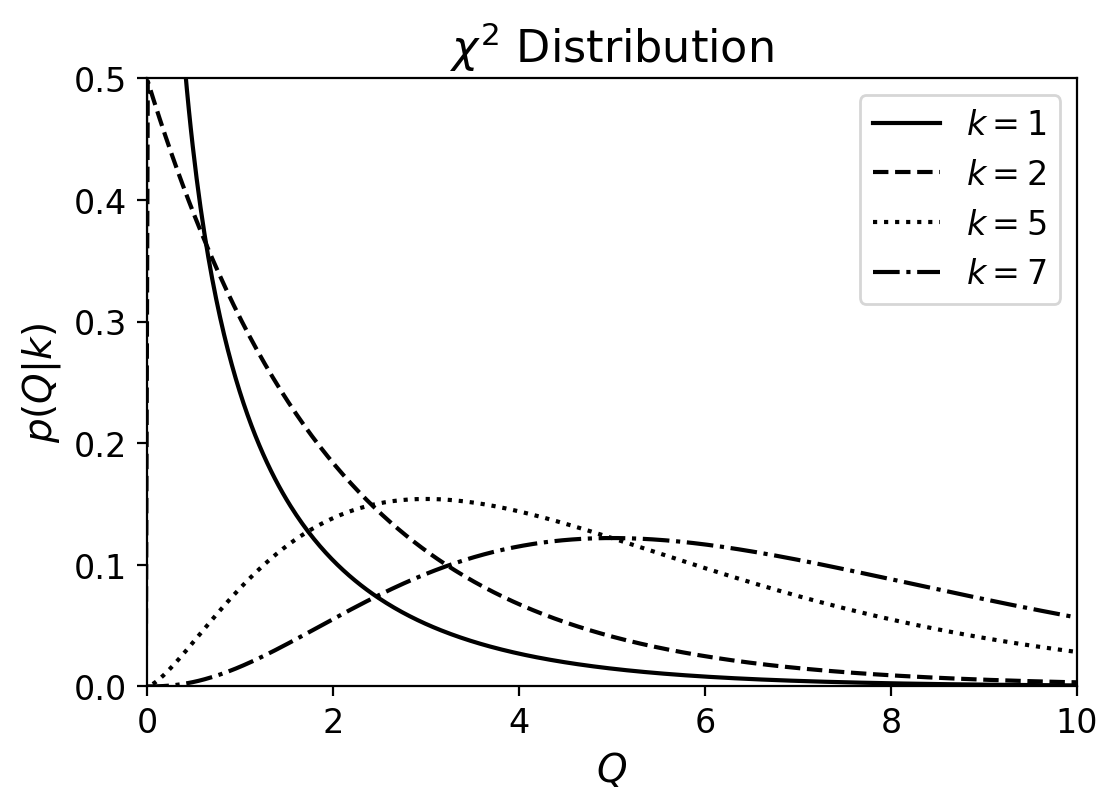

In [36]:
r"""
Example of a chi-squared distribution
---------------------------------------
Figure 3.14.
This shows an example of a :math:`\chi^2` distribution with various parameters.
We'll generate the distribution using::
    dist = scipy.stats.chi2(...)
Where ... should be filled in with the desired distribution parameters
Once we have defined the distribution parameters in this way, these
distribution objects have many useful methods; for example:
* ``dist.pmf(x)`` computes the Probability Mass Function at values ``x``
  in the case of discrete distributions
* ``dist.pdf(x)`` computes the Probability Density Function at values ``x``
  in the case of continuous distributions
* ``dist.rvs(N)`` computes ``N`` random variables distributed according
  to the given distribution
Many further options exist; refer to the documentation of ``scipy.stats``
for more details.
"""
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
from scipy.stats import chi2
from matplotlib import pyplot as plt


#------------------------------------------------------------
# Define the distribution parameters to be plotted
k_values = [1, 2, 5, 7]
linestyles = ['-', '--', ':', '-.']
mu = 0
x = np.linspace(-1, 20, 1000)

#------------------------------------------------------------
# plot the distributions
fig, ax = plt.subplots(figsize=(6,4))
fig.subplots_adjust(bottom=0.12)

for k, ls in zip(k_values, linestyles):
    dist = chi2(k, mu)

    plt.plot(x, dist.pdf(x), ls=ls, c='black',
             label=r'$k=%i$' % k)

plt.xlim(0, 10)
plt.ylim(0, 0.5)

plt.xlabel('$Q$')
plt.ylabel(r'$p(Q|k)$')
plt.title(r'$\chi^2\ \mathrm{Distribution}$')

plt.legend()
plt.show()

### $\chi^2$ per degree of freedom

In practice, we frequently divide $\chi^2$ by the number of degrees of freedom, and work with:

$$\chi^2_\mathrm{dof} = \frac{1}{N-1} \sum_{i=1}^N \left(\frac{x_i-\overline{x}}{\sigma}\right)^2,$$

which (for large $k$) is distributed as

$$ p(\chi^2_\mathrm{dof}) \sim \mathscr{N}\left(1, \sqrt{\frac{2}{N-1}}\right), $$

(where $k = N-1$, and $N$ is the number of samples). Therefore, we expect $\chi^2_\mathrm{dof}$ to be 1, to within a few $\sqrt{\frac{2}{N-1}}$.

### Poisson distribution

This is a distribution for a discrete variable, telling you the probability of $k$ events occurring within a certain time when the mean is $\mu$: 

$$ p(k|\mu) = \frac{\mu^k \exp(-\mu)}{k!}, $$

where the mean $\mu$ completely characterizes the distribution. The mode is $(\mu-1)$ (most probably value as determined from setting derivative to 0), the standard deviation is $\sqrt{\mu}$, the skewness is $1/\sqrt{\mu}$, and the kurtosis is $1/\mu$.

As $\mu$ increases the Poisson distribution becomes more and more similar to a Gaussian with $\mathcal{N}(\mu,\sqrt{\mu})$. The Poisson distribution is sometimes called the ***law of small numbers*** or ***law of rare events***.

In cosmology, when we observe galaxies, there is Poisson noise (which is sometimes called shotnoise) due to the finite number of galaxies, in particular on the faint end. 
Similarly, in dark matter detectors, events are typically modelled as Poisson processes. 

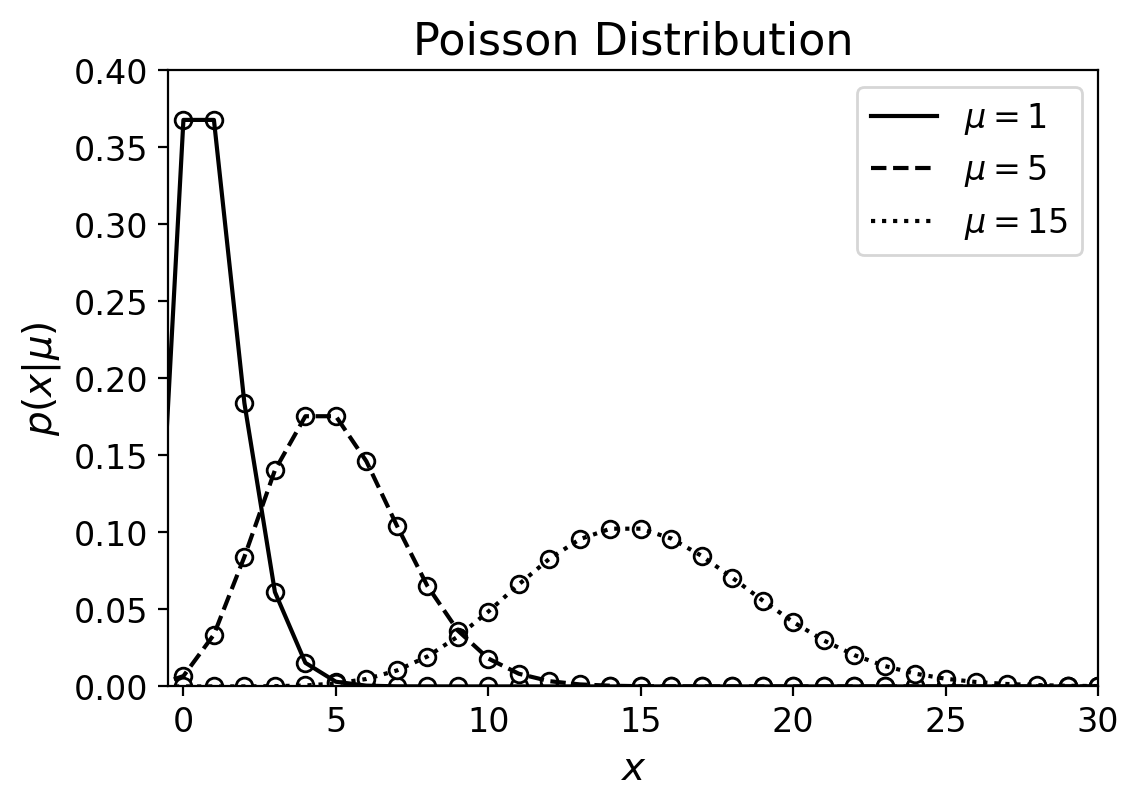

In [37]:
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
from scipy.stats import poisson
from matplotlib import pyplot as plt

#------------------------------------------------------------
# Define the distribution parameters to be plotted
mu_values = [1, 5, 15]
linestyles = ['-', '--', ':']

# plot the distributions
#   we generate it using scipy.stats.poisson().  Once the distribution
#   object is created, we have many options: for example
#   - dist.pmf(x) evaluates the probability mass function in the case of
#     discrete distributions.
#   - dist.pdf(x) evaluates the probability density function for
#   evaluates
fig, ax = plt.subplots(figsize=(6,4))

for mu, ls in zip(mu_values, linestyles):
    # create a poisson distribution
    # we could generate a random sample from this distribution using, e.g.
    #   rand = dist.rvs(1000)
    dist = poisson(mu)
    x = np.arange(-1, 200)

    plt.plot(x, dist.pmf(x), color='black',
             linestyle=ls,
             label=r'$\mu=%i$' % mu)

    plt.scatter(x, dist.pmf(x), edgecolor='black',facecolor='white')
    
plt.xlim(-0.5, 30)
plt.ylim(0, 0.4)

plt.xlabel('$x$')
plt.ylabel(r'$p(x|\mu)$')
plt.title('Poisson Distribution')

plt.legend()
plt.show()

### Student's $t$ Distribution

Another distribution that we'll see later is the Student's $t$ Distribution.

If you have a sample of $N$ measurements, $\{x_i\}$, drawn from a Gaussian distribution, $\mathscr{N}(\mu,\sigma)$, and you apply the transform

$$t = \frac{\overline{x}-\mu}{s/\sqrt{N}},$$

then $t$ will be distributed according to Student's $t$ with the following pdf (for $k$ degrees of freedom):

$$p(x|k) = \frac{\Gamma(\frac{k+1}{2})}{\sqrt{\pi k} \Gamma(\frac{k}{2})} \left(1+\frac{x^2}{k}\right)^{-\frac{k+1}{2}}$$

As with a Gaussian, Student's $t$ is bell shaped, but has "heavier" tails.

Note the similarity between $t$ and $z$ for a Gaussian (as defined in the $\chi^2$ section above), which reflects the difference between data-derived estimates of the mean and standard deviation and their true values.

In fact, although often approximated as a Gaussian distribution, the mean of a sample actually follows a Student's $t$ distribution (**Try this at home: check this property with scipy**). This matters when sample sizes are small, but mostly irrelevant for "Big Data" examples.

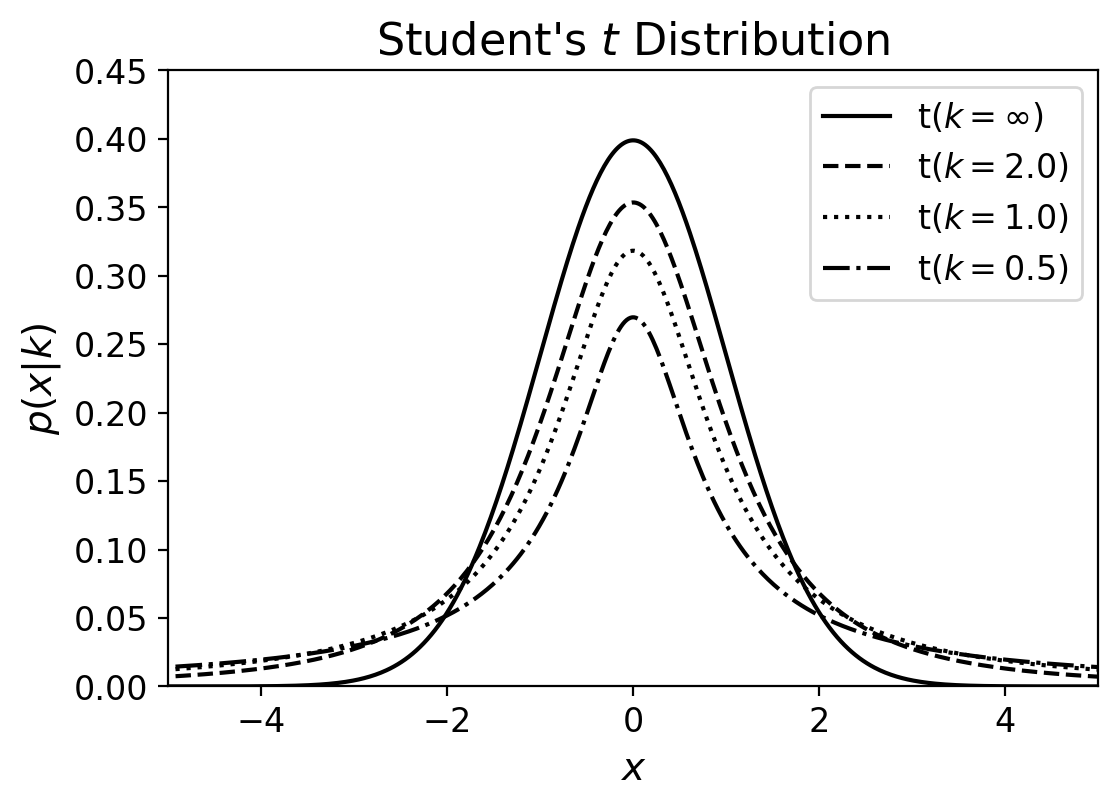

In [38]:
"""
Example of Student's t distribution
-----------------------------------
Figure 3.15.
This shows an example of Student's t distribution with various parameters.
We'll generate the distribution using::
    dist = scipy.stats.student_t(...)
Where ... should be filled in with the desired distribution parameters
Once we have defined the distribution parameters in this way, these
distribution objects have many useful methods; for example:
* ``dist.pmf(x)`` computes the Probability Mass Function at values ``x``
  in the case of discrete distributions
* ``dist.pdf(x)`` computes the Probability Density Function at values ``x``
  in the case of continuous distributions
* ``dist.rvs(N)`` computes ``N`` random variables distributed according
  to the given distribution
Many further options exist; refer to the documentation of ``scipy.stats``
for more details.
"""
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
from scipy.stats import t as student_t
from matplotlib import pyplot as plt


#------------------------------------------------------------
# Define the distribution parameters to be plotted
mu = 0
k_values = [1E10, 2, 1, 0.5]
linestyles = ['-', '--', ':', '-.']
x = np.linspace(-10, 10, 1000)

#------------------------------------------------------------
# plot the distributions
fig, ax = plt.subplots(figsize=(6,4))

for k, ls in zip(k_values, linestyles):
    dist = student_t(k, 0)

    if k >= 1E10:
        label = r'$\mathrm{t}(k=\infty)$'
    else:
        label = r'$\mathrm{t}(k=%.1f)$' % k

    plt.plot(x, dist.pdf(x), ls=ls, c='black', label=label)

plt.xlim(-5, 5)
plt.ylim(0.0, 0.45)

plt.xlabel('$x$')
plt.ylabel(r'$p(x|k)$')
plt.title("Student's $t$ Distribution")

plt.legend()
plt.show()

### What's the point of all these distributions?

* There are many other distributions that we haven't covered here (see the textbook).
* The point is that we are going to make some measurement. 
* To understand the significance of our measurement, we want to know how likely it is that we would get that measurement in our experiment by random chance. 
* To determine that we need to know the shape of the distribution. Let's say that we find that $x=6$. If our data is $\chi^2$ distributed with 2 degrees of freedom, then we would integrate the $k=2$ curve above from 6 to $\infty$ to determine how likely it is that we would have gotten 6 or larger by chance.  If our distribution was instead $t$ distributed, we would get a *very* different answer. --These are all parametric examples.  

Note that it is important that you decide *ahead of time* what the metric will be for deciding whether this result is significant or not.  More on this later, but see [this article](http://fivethirtyeight.com/features/science-isnt-broken/).

**FUN FACT:** "Student" was the pen name of W. S. Gosset, who worked for the Guinness brewery in Dublin, Ireland. He was interested in the statistical analysis of small samples, e.g., the chemical properties of barley when the sample size might be as small as $3$.

![https://thatsmaths.files.wordpress.com/2014/04/gosset-plaque.jpg](https://thatsmaths.files.wordpress.com/2014/04/gosset-plaque.jpg)

---
>##  Assignment: 

**1. A Gaussian integral**

Using Monte Carlo integration, check that

$$ \int_0^\infty x^3 \exp\left(-\frac{x^2}{2\sigma^2}\right) \,dx = 2\sigma^4 .$$

- Does the result converge with the number of samples? And how does the error go down?
- Do it many times. For a given $N$, how are the result distributed? We'll talk about model fitting at lenght later on, but for now try to fit it by hand with a parametrized model. (If N is large enough you should get something that looks *very* accurate! And if $N$ is small?)
- How does the distribution change if $N$ increases?

(Hint: think about sample mean and sample variance)


**2. Kicking horses**

A famous early application of low-number statistics was an analysis of Prussian cavalryman horse-kick deaths by [Bortkiewicz](https://www.wikiwand.com/en/Ladislaus_Bortkiewicz) in 1898.

He studied the distribution of 122 men kicked to death by horses among 10 Prussian army corps within 20 years (so a total number of corps of 200). He recorded the number of corps with a given number of deaths:
[Data](https://www-jstor-org.proxy-ub.rug.nl/stable/1403193?seq=1)
| Number of deaths per corps per year | Number of corps |
| --- | --- |
| 0 | 109 |
| 1 | 65 |
| 2 | 22 |
| 3 | 3 |
| 4 | 1 |

- Plot the resulting probability distribution. Careful with the normalization
- How does it look like? Again try to fit it by hand.

(Hint: think about sample mean and sample variance)
